In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1nI47j3kVW-ZFcUAUSYJVp17wwIs-EpHC
!unzip Scrapping.zip
!rm -rf Scrapping.zip

Downloading...
From: https://drive.google.com/uc?id=1nI47j3kVW-ZFcUAUSYJVp17wwIs-EpHC
To: /content/Scrapping.zip
187MB [00:02, 68.7MB/s]
Archive:  Scrapping.zip
   creating: Train/
   creating: Train/Gapura Candi Bentar/
  inflating: Train/Gapura Candi Bentar/candi bentar0.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar1.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar10.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar11.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar12.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar13.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar14.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar15.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar16.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar17.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar18.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar19.jpg  
  inflating: Train/Gapura Candi Bentar/candi bentar20.jpg  
 

In [ ]:
import os

BASE_PATH = os.getcwd()

if not os.path.exists('/model'):
    !mkdir model
if not os.path.exists('/logs'):
    !mkdir logs

mkdir: cannot create directory ‘model’: File exists
mkdir: cannot create directory ‘logs’: File exists


In [ ]:
import os

train_dir = os.path.join('/content/Train')
test_dir = os.path.join('/content/Test')

print("===TRAINING===")
for i in os.listdir(train_dir):
    print(f'Total Training {i}: {len(os.listdir(os.path.join(train_dir, i)))}')
print("\n===VALIDATION===")
for i in os.listdir(test_dir):
    print(f'Total Validation {i}: {len(os.listdir(os.path.join(test_dir, i)))}')

print(f'\nTotal Class: {len(os.listdir(train_dir))}')

===TRAINING===
Total Training Rumah Joglo: 90
Total Training Mbaru Niang: 98
Total Training Gapura Candi Bentar: 100
Total Training Rumah Honai: 98
Total Training Tongkonan: 86
Total Training Julang Ngapak: 97
Total Training Rumah Panjang: 94
Total Training Rumah Limas: 96
Total Training Rumah Gadang: 102

===VALIDATION===
Total Validation Rumah Joglo: 10
Total Validation Mbaru Niang: 10
Total Validation Gapura Candi Bentar: 10
Total Validation Rumah Honai: 10
Total Validation Tongkonan: 10
Total Validation Julang Ngapak: 10
Total Validation Rumah Panjang: 10
Total Validation Rumah Limas: 10
Total Validation Rumah Gadang: 10

Total Class: 9


In [ ]:
import datetime
import tensorflow as tf
import keras_preprocessing
from tensorflow.keras import layers
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# Pre Processing

In [ ]:
TRAINING_DIR = "/content/Train"
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

VALIDATION_DIR = "/content/Test"
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(160, 160),
                                                       class_mode='categorical',
                                                       interpolation='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              target_size=(160, 160),
                                                              class_mode='categorical',
                                                              interpolation='nearest')

Found 861 images belonging to 9 classes.
Found 90 images belonging to 9 classes.


# Transfer Learning: Arsitektur &  Config

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3))

In [ ]:
# Frezee The Model
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
base_input = base_model.layers[0].input ##input
base_output = base_model.layers[-2].output
# Flat_layer = layers.Flatten()(base_output)
# final_output = layers.Dense(1280)(Flat_layer)
final_output = layers.Dense(9, activation='softmax')(base_output)
# final_output = layers.Activation('softmax')(final_output)

In [ ]:
model = tf.keras.Model(inputs= base_input, outputs= final_output)

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [ ]:
MODEL_PATH = os.path.join('/content/model')
tensorboard_path = os.path.join(
    BASE_PATH, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

checkpoint_path = os.path.join(MODEL_PATH, "save_at_{epoch}")
callbacks = [
             tf.keras.callbacks.ModelCheckpoint(checkpoint_path),
             tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path,
                                            histogram_freq=1),
             tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=2,
                                              mode="auto",
                                              restore_best_weights=True),]

# Adaptation Phase

In [ ]:
lr = 0.0001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(lr),
              metrics=['accuracy'])

In [ ]:
# Initial Epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_generator)

3/3 [==============================] - 4s 667ms/step - loss: 2.6949 - accuracy: 0.1096


In [ ]:
# Error Handling Image Size Inconsistent
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/100
27/27 [==============================] - 33s 1s/step - loss: 2.4389 - accuracy: 0.1394 - val_loss: 2.2317 - val_accuracy: 0.1444
INFO:tensorflow:Assets written to: /content/model/save_at_1/assets
Epoch 2/100
27/27 [==============================] - 32s 1s/step - loss: 2.1926 - accuracy: 0.1963 - val_loss: 2.0661 - val_accuracy: 0.2444
INFO:tensorflow:Assets written to: /content/model/save_at_2/assets
Epoch 3/100
27/27 [==============================] - 32s 1s/step - loss: 2.0295 - accuracy: 0.2625 - val_loss: 1.9372 - val_accuracy: 0.2667
INFO:tensorflow:Assets written to: /content/model/save_at_3/assets
Epoch 4/100
27/27 [==============================] - 32s 1s/step - loss: 1.8831 - accuracy: 0.3159 - val_loss: 1.8138 - val_accuracy: 0.2889
INFO:tensorflow:Assets written to: /content/model/save_at_4/assets
Epoch 5/100
27/27 [==============================] - 32s 1s/step - loss: 1.8029 - accuracy: 0.3577 - val_loss: 1.7048 - val_accuracy: 0.3222
INFO:tensorflow:Assets writ

In [ ]:
model.save('T_house_model_before_fine_tune.h5')

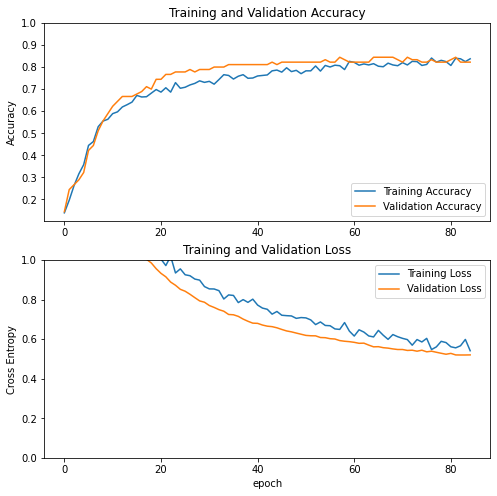

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning (Coming Soon)

In [ ]:
base_model.trainable = True

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [ ]:
callbacks = [
             tf.keras.callbacks.ModelCheckpoint(checkpoint_path),
             tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path,
                                            histogram_freq=1),
             tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=5,
                                              mode="auto",
                                              restore_best_weights=True),]

In [ ]:
lr = 0.0001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(lr/10),
              metrics=['accuracy'])

In [ ]:
history_fine = model.fit(train_generator,
                         epochs=200,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=callbacks,
                         verbose=1)

Epoch 85/200
27/27 [==============================] - 101s 4s/step - loss: 1.1054 - accuracy: 0.6167 - val_loss: 0.4915 - val_accuracy: 0.8444
INFO:tensorflow:Assets written to: /content/model/save_at_85/assets
Epoch 86/200
27/27 [==============================] - 99s 4s/step - loss: 0.9978 - accuracy: 0.6446 - val_loss: 0.4800 - val_accuracy: 0.8444
INFO:tensorflow:Assets written to: /content/model/save_at_86/assets
Epoch 87/200
27/27 [==============================] - 99s 4s/step - loss: 0.9540 - accuracy: 0.6957 - val_loss: 0.4660 - val_accuracy: 0.8556
INFO:tensorflow:Assets written to: /content/model/save_at_87/assets
Epoch 88/200
27/27 [==============================] - 99s 4s/step - loss: 0.8472 - accuracy: 0.7340 - val_loss: 0.4558 - val_accuracy: 0.8667
INFO:tensorflow:Assets written to: /content/model/save_at_88/assets
Epoch 89/200
27/27 [==============================] - 99s 4s/step - loss: 0.8052 - accuracy: 0.7375 - val_loss: 0.4506 - val_accuracy: 0.8667
INFO:tensorflow:A

In [ ]:
model.save('T_house_model_after_fine_tune.h5')

In [ ]:
acc = history.history['accuracy'][0:121]
val_acc = history.history['val_accuracy'][0:121]

loss = history.history['loss'][0:121]
val_loss = history.history['val_loss'][0:121]

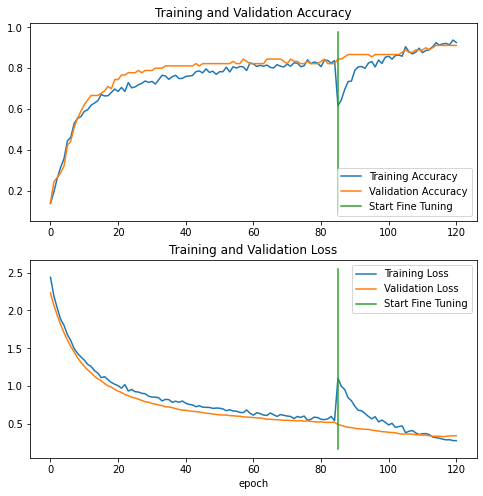

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([85,85],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([85,85],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Optional Step

In [ ]:
!zip -r "/content/model_24_04_2021.zip" "/content/model"
!zip -r "/content/logs_24_04_2021.zip" "/content/logs"

  adding: content/model/ (stored 0%)
  adding: content/model/save_at_25/ (stored 0%)
  adding: content/model/save_at_25/assets/ (stored 0%)
  adding: content/model/save_at_25/saved_model.pb (deflated 93%)
  adding: content/model/save_at_25/variables/ (stored 0%)
  adding: content/model/save_at_25/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model/save_at_25/variables/variables.index (deflated 77%)
  adding: content/model/save_at_85/ (stored 0%)
  adding: content/model/save_at_85/assets/ (stored 0%)
  adding: content/model/save_at_85/saved_model.pb (deflated 92%)
  adding: content/model/save_at_85/variables/ (stored 0%)
  adding: content/model/save_at_85/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model/save_at_85/variables/variables.index (deflated 77%)
  adding: content/model/save_at_62/ (stored 0%)
  adding: content/model/save_at_62/assets/ (stored 0%)
  adding: content/model/save_at_62/saved_model.pb (deflated 93%)
  adding: con